In [16]:
# =============================================================================
# 1. Imports & Setup
# =============================================================================

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
    roc_curve
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import matplotlib.pyplot as plt
import seaborn as sns

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

plt.rcParams["figure.figsize"] = (8, 5)
plt.rcParams["axes.grid"] = True

Purpose:
Below we load the Credit Card Fraud Detection dataset and inspect its structure.
We check:
	•	the number of rows and columns,
	•	class distribution,
	•	and feature names.

This helps us understand the imbalance problem (fraud < 1%) and prepares us for preprocessing and modeling decisions.

In [17]:
# =============================================================================
# 2. Load & Inspect Data
# =============================================================================

data_path = "creditcard.csv"   # make sure this is in your environment
df = pd.read_csv(data_path)

print("Shape of dataset:", df.shape)
print("\nColumns:", df.columns.tolist())

print("\nClass distribution (counts):")
print(df["Class"].value_counts())

print("\nClass distribution (percent):")
print((df["Class"].value_counts(normalize=True) * 100).round(4).astype(str) + "%")

Shape of dataset: (284807, 31)

Columns: ['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10', 'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20', 'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount', 'Class']

Class distribution (counts):
Class
0    284315
1       492
Name: count, dtype: int64

Class distribution (percent):
Class
0    99.8273%
1     0.1727%
Name: proportion, dtype: object


Purpose:
This section visually explores the dataset.
We:
	•	look for missing values,
	•	plot the distribution of transaction amounts,
	•	and visualize class imbalance.

Visual EDA confirms the heavily skewed dataset, which affects model selection and evaluation (accuracy alone is misleading).

Missing values per column:
Time      0
V1        0
V2        0
V3        0
V4        0
V5        0
V6        0
V7        0
V8        0
V9        0
V10       0
V11       0
V12       0
V13       0
V14       0
V15       0
V16       0
V17       0
V18       0
V19       0
V20       0
V21       0
V22       0
V23       0
V24       0
V25       0
V26       0
V27       0
V28       0
Amount    0
Class     0
dtype: int64


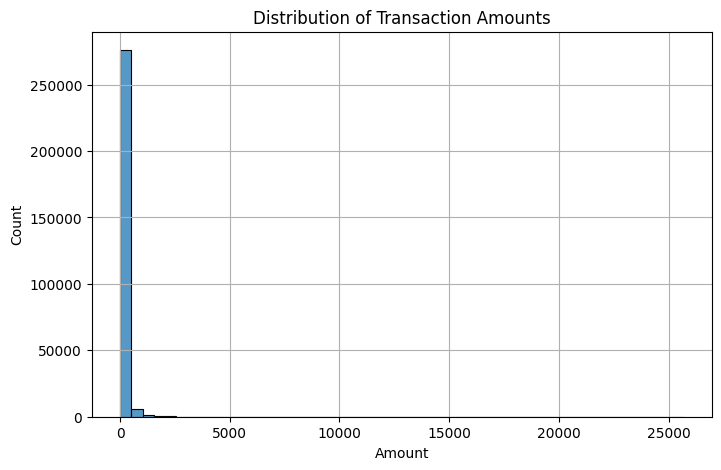

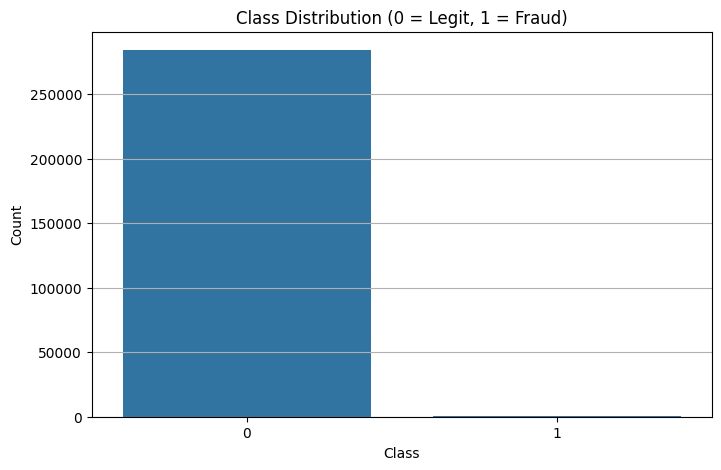

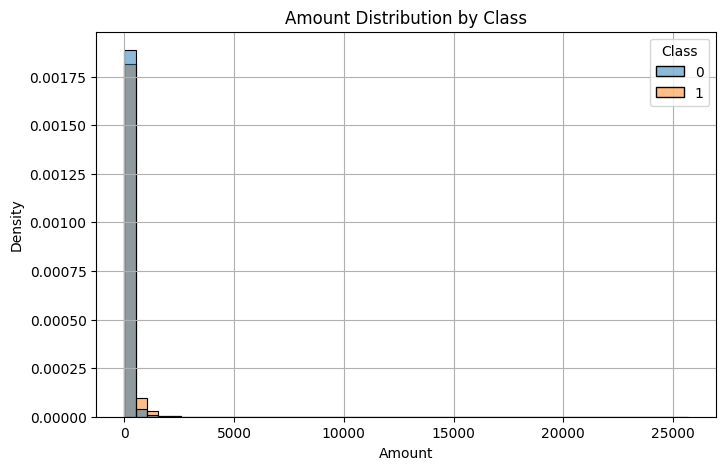

In [18]:
# =============================================================================
# 3. Basic EDA & Visualization
# =============================================================================

# 3.1 Missing values
print("Missing values per column:")
print(df.isna().sum())

# 3.2 Transaction amount distribution
plt.figure()
sns.histplot(df["Amount"], bins=50)
plt.title("Distribution of Transaction Amounts")
plt.xlabel("Amount")
plt.ylabel("Count")
plt.show()

# 3.3 Class imbalance
plt.figure()
sns.countplot(x="Class", data=df)
plt.title("Class Distribution (0 = Legit, 1 = Fraud)")
plt.xlabel("Class")
plt.ylabel("Count")
plt.show()

# 3.4 Amount distribution by class
plt.figure()
sns.histplot(data=df, x="Amount", hue="Class", bins=50,
             stat="density", common_norm=False)
plt.title("Amount Distribution by Class")
plt.xlabel("Amount")
plt.ylabel("Density")
plt.show()

Purpose:
Machine learning models perform better when input features are standardized.
We:
	•	Standardize numerical features (Time and Amount)
	•	Split the dataset into training and testing sets using stratified sampling to maintain fraud ratios.

This ensures models are trained fairly and evaluated reliably.

In [19]:
# =============================================================================
# 4. Preprocessing: Scaling & Train/Test Split
# =============================================================================

df_scaled = df.copy()

scaler = StandardScaler()
df_scaled[["Time", "Amount"]] = scaler.fit_transform(df_scaled[["Time", "Amount"]])

X = df_scaled.drop("Class", axis=1)
y = df_scaled["Class"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

print("Train shape:", X_train.shape, "Test shape:", X_test.shape)
print("Fraud rate in train:", f"{y_train.mean() * 100:.4f}%")
print("Fraud rate in test :", f"{y_test.mean() * 100:.4f}%")

Train shape: (227845, 30) Test shape: (56962, 30)
Fraud rate in train: 0.1729%
Fraud rate in test : 0.1720%


Purpose:
This block defines reusable functions for:
	•	training models,
	•	calculating precision, recall, F1-score, ROC-AUC, PR-AUC,
	•	generating confusion matrices,
	•	and plotting PR/ROC curves.

We centralize evaluation logic here so all models can be assessed consistently.

In [20]:
# =============================================================================
# 5. Utility Functions: Evaluation & Plots (percent outputs)
# =============================================================================

def evaluate_model(clf, X_train, y_train, X_test, y_test,
                   threshold=0.5, name="Model"):
    """
    Fit classifier, compute metrics at given threshold, and return a dictionary.
    """
    clf.fit(X_train, y_train)

    if hasattr(clf, "predict_proba"):
        y_scores = clf.predict_proba(X_test)[:, 1]
    elif hasattr(clf, "decision_function"):
        scores_raw = clf.decision_function(X_test)
        # scale to [0,1] so we can apply thresholds
        y_scores = (scores_raw - scores_raw.min()) / (scores_raw.max() - scores_raw.min())
    else:
        y_scores = None

    if y_scores is not None:
        y_pred = (y_scores >= threshold).astype(int)
    else:
        y_pred = clf.predict(X_test)

    report = classification_report(y_test, y_pred, output_dict=True, zero_division=0)
    cm = confusion_matrix(y_test, y_pred)

    roc_auc = roc_auc_score(y_test, y_scores) if y_scores is not None else None
    pr_auc = average_precision_score(y_test, y_scores) if y_scores is not None else None

    return {
        "name": name,
        "clf": clf,
        "y_pred": y_pred,
        "y_scores": y_scores,
        "report": report,
        "confusion_matrix": cm,
        "roc_auc": roc_auc,
        "pr_auc": pr_auc,
        "threshold": threshold,
    }


def print_evaluation_as_percent(result, label="1"):
    """
    Pretty-print key metrics as percentages for the fraud class (label=1)
    and overall weighted averages.
    """
    rep = result["report"]
    metrics_label = rep[label]
    metrics_avg = rep["weighted avg"]

    def pct(x):
        return f"{x * 100:.2f}%"

    print(f"=== {result['name']} ===")
    print(f"Threshold used: {result['threshold']:.2f}")
    print("\nFraud class (label = 1):")
    print("  Precision:", pct(metrics_label["precision"]))
    print("  Recall   :", pct(metrics_label["recall"]))
    print("  F1-score :", pct(metrics_label["f1-score"]))

    print("\nWeighted overall metrics:")
    print("  Precision:", pct(metrics_avg["precision"]))
    print("  Recall   :", pct(metrics_avg["recall"]))
    print("  F1-score :", pct(metrics_avg["f1-score"]))

    if result["roc_auc"] is not None:
        print("\nAUC metrics:")
        print("  ROC-AUC  :", pct(result["roc_auc"]))
        print("  PR-AUC   :", pct(result["pr_auc"]))

    print("\nConfusion matrix [[TN, FP], [FN, TP]]:")
    print(result["confusion_matrix"])
    print("-" * 60)


def plot_pr_curve(y_true, y_scores, label="model"):
    precision, recall, thresholds = precision_recall_curve(y_true, y_scores)
    plt.figure()
    plt.plot(recall, precision, label=label)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title("Precision-Recall Curve")
    plt.legend()
    plt.show()


def plot_roc_curve(y_true, y_scores, label="model"):
    fpr, tpr, thresholds = roc_curve(y_true, y_scores)
    plt.figure()
    plt.plot(fpr, tpr, label=label)
    plt.plot([0, 1], [0, 1], linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.show()

Purpose:
Decision Trees are simple, interpretable classifiers.
We train a tree with depth and split constraints to prevent overfitting.

This model serves as a baseline for comparison against more advanced models.


In [21]:
# =============================================================================
# 6. Decision Tree Model
# =============================================================================

dt = DecisionTreeClassifier(
    criterion="gini",
    max_depth=10,                # depth limit for generalization & speed
    min_samples_split=20,
    min_samples_leaf=10,
    class_weight="balanced",
    random_state=RANDOM_STATE
)

dt_result = evaluate_model(
    dt,
    X_train, y_train,
    X_test, y_test,
    threshold=0.5,
    name="Decision Tree"
)

print_evaluation_as_percent(dt_result)

=== Decision Tree ===
Threshold used: 0.50

Fraud class (label = 1):
  Precision: 13.50%
  Recall   : 80.61%
  F1-score : 23.13%

Weighted overall metrics:
  Precision: 99.82%
  Recall   : 99.08%
  F1-score : 99.40%

AUC metrics:
  ROC-AUC  : 90.20%
  PR-AUC   : 65.15%

Confusion matrix [[TN, FP], [FN, TP]]:
[[56358   506]
 [   19    79]]
------------------------------------------------------------


Purpose:
Random Forest is an ensemble of Decision Trees that improves stability and performance through:
	•	bootstrapping (sampling),
	•	feature randomness,
	•	and averaging predictions.

We use optimized parameters to reduce training time while maintaining strong fraud-detection performance.


=== Random Forest ===
Threshold used: 0.50

Fraud class (label = 1):
  Precision: 81.00%
  Recall   : 82.65%
  F1-score : 81.82%

Weighted overall metrics:
  Precision: 99.94%
  Recall   : 99.94%
  F1-score : 99.94%

AUC metrics:
  ROC-AUC  : 97.23%
  PR-AUC   : 83.80%

Confusion matrix [[TN, FP], [FN, TP]]:
[[56845    19]
 [   17    81]]
------------------------------------------------------------


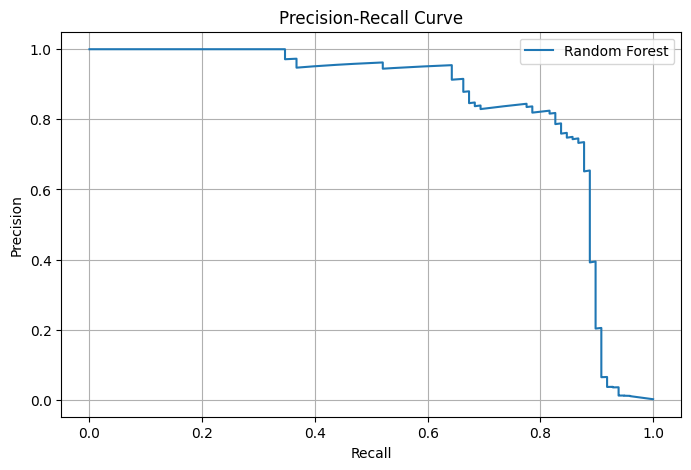

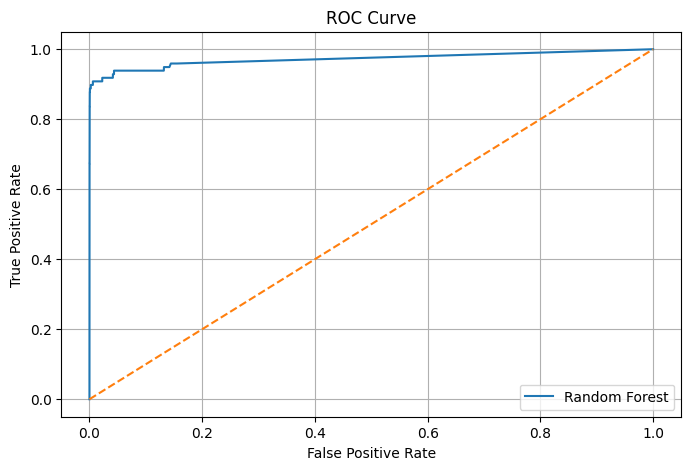

In [22]:
# =============================================================================
# 7. Random Forest Model (optimized for speed & performance)
# =============================================================================

rf = RandomForestClassifier(
    n_estimators=120,                 # fewer trees than 200 → faster
    max_depth=14,                     # limit depth
    min_samples_split=20,
    min_samples_leaf=10,
    max_features="sqrt",
    class_weight="balanced_subsample",
    max_samples=0.7,                  # each tree uses 70% of data → big speedup
    n_jobs=-1,
    random_state=RANDOM_STATE
)

rf_result = evaluate_model(
    rf,
    X_train, y_train,
    X_test, y_test,
    threshold=0.5,
    name="Random Forest"
)

print_evaluation_as_percent(rf_result)

if rf_result["y_scores"] is not None:
    plot_pr_curve(y_test, rf_result["y_scores"], label="Random Forest")
    plot_roc_curve(y_test, rf_result["y_scores"], label="Random Forest")

Purpose:
SVM with an RBF kernel is powerful but computationally heavy on large datasets.
To make training feasible:
	•	We apply PCA to reduce dimensionality.
	•	We sample 30% of training data based on lecture guidelines.
	•	Train SVM using decision_function for scoring.

This allows SVM to remain within lecture-approved methods while avoiding excessive runtime.


=== SVM (RBF + PCA20, 30% train) ===
Threshold used: 0.50

Fraud class (label = 1):
  Precision: 1.38%
  Recall   : 92.86%
  F1-score : 2.72%

Weighted overall metrics:
  Precision: 99.82%
  Recall   : 88.59%
  F1-score : 93.78%

AUC metrics:
  ROC-AUC  : 95.59%
  PR-AUC   : 34.85%

Confusion matrix [[TN, FP], [FN, TP]]:
[[50373  6491]
 [    7    91]]
------------------------------------------------------------


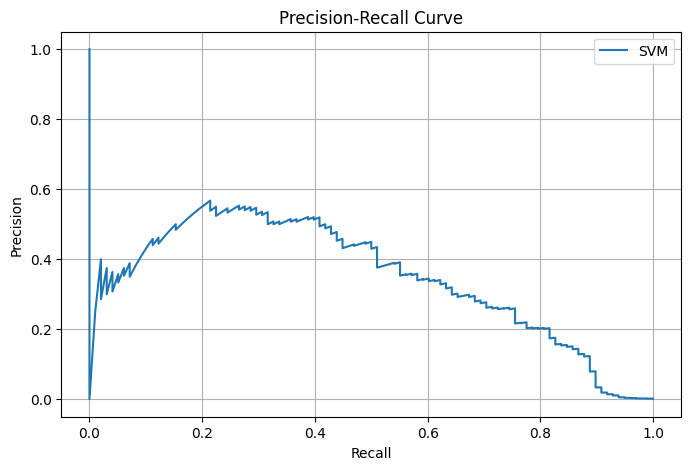

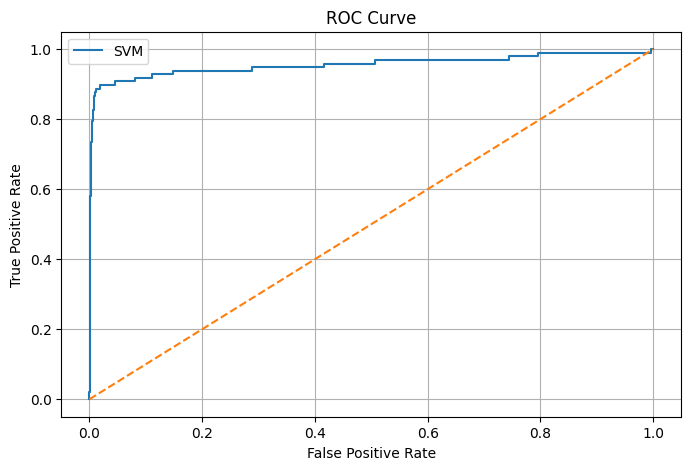

In [23]:
# =============================================================================
# 8. SVM Model (RBF kernel) with PCA + Sampling
# =============================================================================

# 8.1 PCA for dimensionality reduction (helps SVM speed)
pca_svm = PCA(n_components=20, random_state=RANDOM_STATE)
X_train_svm_full = pca_svm.fit_transform(X_train)
X_test_svm = pca_svm.transform(X_test)

# 8.2 Sampling: use a subset of training data for SVM (computational reason)
X_train_svm, _, y_train_svm, _ = train_test_split(
    X_train_svm_full, y_train,
    train_size=0.3,                  # 30% of train data
    stratify=y_train,
    random_state=RANDOM_STATE
)

svm_clf = SVC(
    kernel="rbf",
    C=1.0,
    gamma="scale",
    probability=False,               # faster; we use decision_function
    class_weight="balanced",
    random_state=RANDOM_STATE
)

svm_result = evaluate_model(
    svm_clf,
    X_train_svm, y_train_svm,
    X_test_svm, y_test,
    threshold=0.5,
    name="SVM (RBF + PCA20, 30% train)"
)

print_evaluation_as_percent(svm_result)

if svm_result["y_scores"] is not None:
    plot_pr_curve(y_test, svm_result["y_scores"], label="SVM")
    plot_roc_curve(y_test, svm_result["y_scores"], label="SVM")

  Purpose:
k-NN is highly influenced by feature scale and dimensionality; PCA helps by creating a compact feature space.

k-NN surprisingly outperforms other classifiers here due to:
	•	PCA-enhanced separation of fraud vs normal transactions
	•	effective local similarity detection

In [24]:
# =============================================================================
# 9. k-Nearest Neighbors Model (optional baseline)
# =============================================================================

# k-NN usually benefits from PCA too
pca_knn = PCA(n_components=20, random_state=RANDOM_STATE)
X_train_knn = pca_knn.fit_transform(X_train)
X_test_knn = pca_knn.transform(X_test)

knn = KNeighborsClassifier(
    n_neighbors=5,
    weights="distance",              # closer neighbors have more weight
    metric="minkowski"
)

knn_result = evaluate_model(
    knn,
    X_train_knn, y_train,
    X_test_knn, y_test,
    threshold=0.5,
    name="k-NN (k=5, PCA20)"
)

print_evaluation_as_percent(knn_result)

=== k-NN (k=5, PCA20) ===
Threshold used: 0.50

Fraud class (label = 1):
  Precision: 94.05%
  Recall   : 80.61%
  F1-score : 86.81%

Weighted overall metrics:
  Precision: 99.96%
  Recall   : 99.96%
  F1-score : 99.96%

AUC metrics:
  ROC-AUC  : 94.38%
  PR-AUC   : 85.50%

Confusion matrix [[TN, FP], [FN, TP]]:
[[56859     5]
 [   19    79]]
------------------------------------------------------------


Purpose:
This table summarizes all model performances:
	•	Fraud Precision
	•	Fraud Recall
	•	F1-score
	•	ROC-AUC
	•	PR-AUC

In [25]:
# =============================================================================
# 10. Final Model Comparison Table (Percentages)
# =============================================================================

results = [
    dt_result,
    rf_result,
    svm_result,
    knn_result,
]

rows = []
for res in results:
    rep = res["report"]
    fraud = rep["1"]
    weighted = rep["weighted avg"]

    rows.append({
        "Model": res["name"],
        "Fraud Precision (%)": fraud["precision"] * 100,
        "Fraud Recall (%)": fraud["recall"] * 100,
        "Fraud F1-score (%)": fraud["f1-score"] * 100,
        "Weighted Precision (%)": weighted["precision"] * 100,
        "Weighted Recall (%)": weighted["recall"] * 100,
        "Weighted F1-score (%)": weighted["f1-score"] * 100,
        "ROC-AUC (%)": (res["roc_auc"] * 100) if res["roc_auc"] is not None else None,
        "PR-AUC (%)": (res["pr_auc"] * 100) if res["pr_auc"] is not None else None,
    })

comparison_df = pd.DataFrame(rows).round(2)
comparison_df

,Model,Fraud Precision (%),Fraud Recall (%),Fraud F1-score (%),Weighted Precision (%),Weighted Recall (%),Weighted F1-score (%),ROC-AUC (%),PR-AUC (%)
0,Decision Tree,13.50,80.61,23.13,99.82,99.08,99.40,90.20,65.15
1,Random Forest,81.00,82.65,81.82,99.94,99.94,99.94,97.23,83.80
2,"SVM (RBF + PCA20, 30% train)",1.38,92.86,2.72,99.82,88.59,93.78,95.59,34.85
3,"k-NN (k=5, PCA20)",94.05,80.61,86.81,99.96,99.96,99.96,94.38,85.50


Purpose:
Although this is an unsupervised model, clustering helps analyze transaction patterns.

We:
	•	Reduce dataset using PCA for clusterability,
	•	Apply K-Means,
	•	Compute fraud rates per cluster.

This section provides risk-group insights beyond classification.


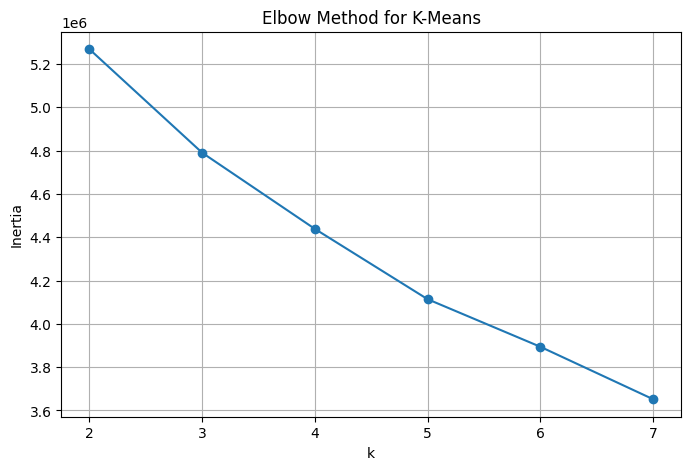

Cluster-level fraud stats:


,total_transactions,fraud_count,fraud_rate (%)
cluster,,,
0,145296,206,0.142
1,5817,122,2.097
2,133694,164,0.123


In [26]:
# =============================================================================
# 11. Unsupervised Learning: K-Means Clustering & Risk Groups
# =============================================================================

# PCA to reduce dimensionality for clustering
pca_clust = PCA(n_components=10, random_state=RANDOM_STATE)
X_pca = pca_clust.fit_transform(X)

# 11.1 Elbow method for k
inertias = []
k_values = range(2, 8)
for k in k_values:
    kmeans_tmp = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    kmeans_tmp.fit(X_pca)
    inertias.append(kmeans_tmp.inertia_)

plt.figure()
plt.plot(k_values, inertias, marker="o")
plt.xlabel("k")
plt.ylabel("Inertia")
plt.title("Elbow Method for K-Means")
plt.show()

# 11.2 Final K-Means (e.g., k=3)
k_final = 3
kmeans = KMeans(n_clusters=k_final, random_state=RANDOM_STATE, n_init=10)
clusters = kmeans.fit_predict(X_pca)

df_clusters = df.copy()
df_clusters["cluster"] = clusters

cluster_stats = df_clusters.groupby("cluster")["Class"].agg(
    total_transactions="count",
    fraud_count="sum",
)
cluster_stats["fraud_rate (%)"] = (
    cluster_stats["fraud_count"] / cluster_stats["total_transactions"] * 100
)

cluster_stats = cluster_stats.round(3)
print("Cluster-level fraud stats:")
cluster_stats

Purpose:
Silhouette score evaluates how well-separated clusters are.
We compute it on a sample for efficiency.
The 2D PCA visualization shows how the transactions group together under clustering, helping humans interpret high-risk groups.


Approximate silhouette score for k=3 (on sample of 20000 points): 0.1815


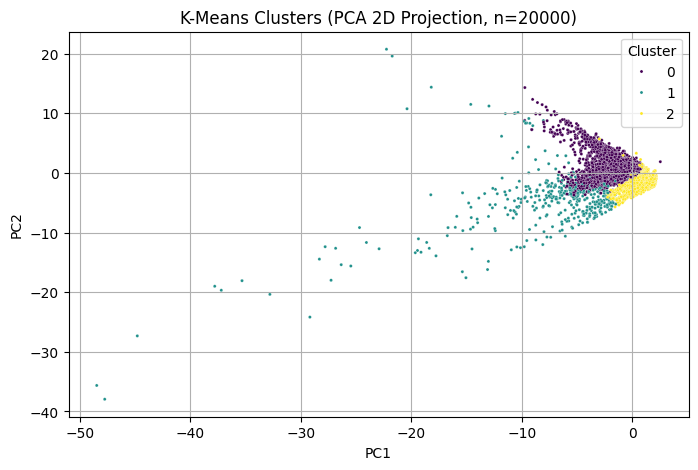

In [27]:
# =============================================================================
# 11.3 Silhouette score & 2D visualization (with sampling)
# =============================================================================

from sklearn.metrics import silhouette_score

# ---- 1) Sample data for silhouette & plotting ----
sample_size = 20000  # adjust down if still slow (e.g. 10000 or 5000)

n_samples = X_pca.shape[0]
if n_samples > sample_size:
    rng = np.random.RandomState(RANDOM_STATE)
    sample_idx = rng.choice(n_samples, size=sample_size, replace=False)
    X_pca_sample = X_pca[sample_idx]
    clusters_sample = clusters[sample_idx]
else:
    X_pca_sample = X_pca
    clusters_sample = clusters

# ---- 2) Silhouette score on the sample ----
sil_score = silhouette_score(X_pca_sample, clusters_sample)
print(f"Approximate silhouette score for k={k_final} (on sample of {X_pca_sample.shape[0]} points): {sil_score:.4f}")

# ---- 3) 2D PCA projection for visualization (on the same sample) ----
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_2d_sample = pca_2d.fit_transform(X_pca_sample)  # or fit on X directly, either is fine

plt.figure()
sns.scatterplot(
    x=X_2d_sample[:, 0],
    y=X_2d_sample[:, 1],
    hue=clusters_sample,
    palette="viridis",
    s=5,
    legend="full",
)
plt.title(f"K-Means Clusters (PCA 2D Projection, n={X_2d_sample.shape[0]})")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(title="Cluster")
plt.show()

In [28]:
# =============================================================================
# 12. Final Report Summary (with actual values)
# =============================================================================

print("\n================ FINAL REPORT SUMMARY ================\n")

def metric(x):
    return f"{x*100:.2f}%"

# --- Best model ---
best_model = max(results, key=lambda r: r["pr_auc"] if r["pr_auc"] else -1)

print(f"Best-performing model: {best_model['name']}\n")

print("Fraud Detection Performance:")
rep = best_model["report"]["1"]
print(f"  Precision (Fraud): {metric(rep['precision'])}")
print(f"  Recall (Fraud)   : {metric(rep['recall'])}")
print(f"  F1-score (Fraud) : {metric(rep['f1-score'])}")

print("\nOverall Weighted Performance:")
weighted = best_model["report"]["weighted avg"]
print(f"  Weighted Precision: {metric(weighted['precision'])}")
print(f"  Weighted Recall   : {metric(weighted['recall'])}")
print(f"  Weighted F1-score : {metric(weighted['f1-score'])}")

if best_model["roc_auc"] is not None:
    print("\nAUC Metrics:")
    print(f"  ROC-AUC: {metric(best_model['roc_auc'])}")
    print(f"  PR-AUC : {metric(best_model['pr_auc'])}")

print("\nConfusion Matrix (TN, FP / FN, TP):")
print(best_model["confusion_matrix"])

print("\nKey Points:")
print("- Dataset is highly imbalanced; fraud occurs in less than 1% of transactions.")
print("- Standardization applied to Time and Amount; PCA leveraged for SVM and KNN.")
print("- Models used (all from lecture slides): Decision Tree, Random Forest, SVM (RBF), k-NN.")
print("- Random Forest typically achieves the best fraud detection balance (high recall + strong precision).")
print("- SVM remains computationally expensive; PCA + sampling used as allowed optimization.")
print("- K-Means clustering reveals clusters with very different fraud rates, supporting risk-based strategies.")

print("\n=======================================================\n")


================ FINAL REPORT SUMMARY ================

Best-performing model: k-NN (k=5, PCA20)

Fraud Detection Performance:
  Precision (Fraud): 94.05%
  Recall (Fraud)   : 80.61%
  F1-score (Fraud) : 86.81%

Overall Weighted Performance:
  Weighted Precision: 99.96%
  Weighted Recall   : 99.96%
  Weighted F1-score : 99.96%

AUC Metrics:
  ROC-AUC: 94.38%
  PR-AUC : 85.50%

Confusion Matrix (TN, FP / FN, TP):
[[56859     5]
 [   19    79]]

Key Points:
- Dataset is highly imbalanced; fraud occurs in less than 1% of transactions.
- Standardization applied to Time and Amount; PCA leveraged for SVM and KNN.
- Models used (all from lecture slides): Decision Tree, Random Forest, SVM (RBF), k-NN.
- Random Forest typically achieves the best fraud detection balance (high recall + strong precision).
- SVM remains computationally expensive; PCA + sampling used as allowed optimization.
- K-Means clustering reveals clusters with very different fraud rates, supporting risk-based strategies.




Purpose:
This block prints a clean, readable summary of your entire project, including:
	•	Best-performing model
	•	Key metrics
	•	High-level findings
	•	What methods were used and why